# Linear Regression


In this notebook , our focus is on implementing linear regression for hedging purposes. To start off, we will begin by implementing some utility functions that will assist us in this process.
![](https://miro.medium.com/v2/resize:fit:1200/1*tqBA_mQw1UExgVaF-JBneg.png)
### Implementation of Helpful Functions for Linear Regression Hedge Model

In [1]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import os
import copy
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from pandas.tseries.offsets import BDay

This function performs rolling linear regression on the provided dataframe and calculates delta values. It provides flexibility to include additional features, leverage calculations, and customization based on different parameters.

Rolling linear regression refers to the process of applying a linear regression model to a sliding window of data points. Instead of performing regression on the entire dataset at once, it is done iteratively on sequential subsets of the data.

In the context of this code, rolling linear regression is performed within each test period and group. It means that for each period and group combination, the code divides the data into training and testing subsets. The regression model is then fitted using the training data, and the resulting coefficients are used to predict target values for the corresponding testing data.

By sliding the window through the dataset, the regression model is updated and applied to different subsets, capturing any changes or patterns in the relationship between the predictors and the target variable over time or across different groups. 

Code explanation:
This code defines the `run_linear_regression` function, which performs rolling linear regression. The function takes several input parameters and returns a dictionary containing the resulting dataframes.

- The function then initializes variables and data structures for storing the regression coefficients, fit standard deviations, and leverage values (if applicable).
- The code loops through each test period and group in the dataframe. It separates the data into training and testing subsets based on the period and group.
- Linear regression is performed on the training data, where the target variable is calculated based on the taret_var parameter and the feature values are multiplied by a factor derived from the stock prices.
- The regression model is fitted, and the predicted target values, residuals, and standard deviations are calculated.
- If the leverage parameter is set to True, an additional regression is performed on a subset of the training data, and the leverage values are computed based on the regression coefficients.
- The regression coefficients, fit standard deviations, and leverage values are stored in their respective dataframes.
- Delta values are predicted for the testing data using the regression model.
- The delta values are calculated based on the taret_var parameter and the 'delta_bs' column of the original dataframe.
- Finally, a dictionary containing the resulting dataframes is returned.

In [2]:
def run_linear_regression(sub_res=None, setup_name=None, features=None, df=None, max_period=None, taret_var=None, leverage=False):
    """
    Run the linear regression and store the results in dataframes.
    """

    # Perform rolling linear regression
    deltas = pd.Series(index=df.index)
    cols_by = ['cp_int']
    
    grouped = df.groupby(by=cols_by)
    group_names = [str(x) for x in grouped.groups.keys()]
    tmp = pd.MultiIndex.from_product([group_names, features])
    df_coef, df_fit_std = [pd.DataFrame(index=range(max_period+1), columns=tmp) for _ in range(2)]
    df_leverage = pd.DataFrame(index=range(max_period+1), columns=group_names) if leverage else None

    for i in range(0, max_period + 1):
        for name, group in grouped:
            is_train = (group[f'period{i}'] == 0) | (group[f'period{i}'] == 1)
            is_test = (group[f'period{i}'] == 2)

            df_train = group.loc[is_train].copy()
            df_test = group.loc[is_test].copy()
 
            if taret_var:
                target = df_train['V1_n'] - df_train['V0_n'] * df_train['on_ret'] - df_train['delta_bs'] * (
                            df_train['S1_n'] - df_train['S0_n'] * df_train['on_ret'])
            else:
                target = df_train['V1_n'] - df_train['V0_n'] * df_train['on_ret']

            predictors = df_train[features].copy()
            predictors = predictors.multiply(df_train['S1_n'] - df_train['S0_n'] * df_train['on_ret'], axis=0)

            regression = LinearRegression(fit_intercept=False).fit(predictors, target)

            predicted_target = regression.predict(predictors)
            residual = (target - predicted_target)
            residual_sum_of_squares = (residual ** 2).sum()
            sigma_square_hat = residual_sum_of_squares / (predictors.shape[0] - predictors.shape[1])
            var_beta = (np.linalg.inv(predictors.T @ predictors) * sigma_square_hat)
            std = [var_beta[i, i] ** 0.5 for i in range(len(var_beta))]

            if leverage:
                is_leverage = df_train['implvol1'].notna()
                df_leverage = df_train.loc[is_leverage]
                predictors_leverage = (df_leverage['S1_n'] - df_leverage['S0_n']).values.reshape(-1, 1)
                target_leverage = df_leverage['implvol1'] - df_leverage['implvol0']
                leverage_regression = LinearRegression(fit_intercept=False).fit(predictors_leverage, target_leverage)
                var = (leverage_regression.coef_ * df_leverage['vega_n'] / df_leverage['delta_bs']).mean()
                df_leverage.loc[i, str(name)] = var

            df_coef.loc[i, str(name)] = regression.coef_
            df_fit_std.loc[i, str(name)] = std

            df_delta = pd.Series(index=df_test.index)
            delta = regression.predict(df_test.loc[:, features])
            df_delta.loc[:] = delta
            deltas.loc[df_test.index] = df_delta

    # Calculate delta based on taret_var
    if not taret_var:
        delta = deltas
        results_dict[setup_name] = delta
    else:
        delta = deltas + df['delta_bs']
        results_dict[setup_name] = delta 
    return {'df_coef': df_coef, 'df_leverage': df_leverage, 'df_fit_std': df_fit_std}

`modify_dataframe` function takes a dataframe, original size, minimum moneyness, and maximum moneyness as input. It removes in-the-money samples and shrinks the moneyness range in the dataframe. It prints information about the sample removal, such as the number of removed samples and the percentage of remaining data.

The `modify_dataframe` function shrinks the moneyness range by removing samples that fall outside the specified range.

code explanation:

1. It first checks whether each sample in the dataframe meets the criteria for being considered in-the-money. For call options, the condition is `df['cp_int'] == 0` and `df['M0'] < 1.001`. For put options, the condition is `df['cp_int'] == 1` and `df['M0'] > 0.999`. The bitwise OR operator (`|`) combines these conditions.

2. It calculates the number of samples that meet the in-the-money condition and calculates the percentage of removed samples based on the original size of the dataframe.

3. It filters the dataframe to keep only the samples that satisfy the in-the-money condition using the `loc` function.

4. Next, it checks whether each sample's moneyness value (`M0`) falls within the specified range (`MIN_MONEYNESS` to `MAX_MONEYNESS`). It uses the bitwise AND operator (`&`) to combine the conditions.

5. It calculates the number of samples that fall outside the moneyness range and calculates the corresponding removal percentage.

6. It filters the dataframe again to retain only the samples that fall within the desired moneyness range using the `loc` function.

7. Finally, it returns the modified dataframe.

In summary, the `modify_dataframe` function removes samples that are considered in-the-money or fall outside the specified moneyness range, effectively shrinking the moneyness range of the dataset.

In [3]:
def modify_dataframe(dataframe, original_size, MIN_MONEYNESS, MAX_MONEYNESS):
    """
    Remove in-the-money samples and shrink the moneyness range in the dataframe.
    Print information about sample removal.
    """

    # Remove in-the-money samples
    in_the_money = ((dataframe['cp_int'] == 0) & (dataframe['M0'] < 1.001)) | ((dataframe['cp_int'] == 1) & (dataframe['M0'] > 0.999))
    removed_count = dataframe.shape[0] - sum(in_the_money)
    removal_percentage = (removed_count / dataframe.shape[0]) * 100
    remaining_percentage = (sum(in_the_money) / original_size) * 100
    print(f"Removing in-the-money samples: {removed_count} samples ({removal_percentage:.2f}%) removed. "
          f"{remaining_percentage:.2f}% of data remaining. Current size of data: {sum(in_the_money)}.")

    dataframe = dataframe.loc[in_the_money]

    # Shrink moneyness range
    within_moneyness_range = (dataframe['M0'] >= MIN_MONEYNESS - 0.001) & (dataframe['M0'] <= MAX_MONEYNESS + 0.001)
    removed_count = dataframe.shape[0] - sum(within_moneyness_range)
    removal_percentage = (removed_count / dataframe.shape[0]) * 100
    remaining_percentage = (sum(within_moneyness_range) / original_size) * 100
    print(f"Shrinking moneyness range: {removed_count} samples ({removal_percentage:.2f}%) removed. "
          f"{remaining_percentage:.2f}% of data remaining. Current size of data: {sum(within_moneyness_range)}.")

    dataframe = dataframe.loc[within_moneyness_range]
    return dataframe

The `remove_columns_rename` function is responsible for removing specific columns from a dataframe and renaming certain columns based on provided dictionaries. It removes specific columns from the dataframe based on the provided `whole_dictionary` and renames certain columns using the `renaming_dictionary`. This allows for selective column removal and renaming in the dataframe.


Code explanation:

1. The function takes four parameters: `dataframe` (the input dataframe), `whole_dictionary` (a dictionary containing column information), `single_key` (a key from `whole_dictionary`), and `future_volume` (an optional parameter indicating whether to consider the future volume column).

2. It creates a copy of the `whole_dictionary` called `remove_frequency` to prevent modifying the original dictionary.

3. The function removes columns from the dataframe based on the values in `remove_frequency`. It iterates over the items in `remove_frequency` using a for loop.

4. For each item, it retrieves the tag (value[1]) and identifies columns in the dataframe that contain this tag. It uses a list comprehension to create a list of columns to be removed.

5. It then iterates over the columns to be removed and deletes them from the dataframe using the `del` keyword.

6. Next, it creates a dictionary called `renaming_dictionary` to store the renaming mappings for specific columns. The dictionary is populated based on the provided `single_key` and the values in `whole_dictionary`.

7. The dictionary maps the original column names to their corresponding new names. For example, if `whole_dictionary[single_key][1]` is equal to 2, it renames columns with the pattern `S2` to `S1` and so on.

8. If `future_volume` is `True`, it adds an additional mapping for the volume column.

9. Finally, it applies the renaming_dictionary to the dataframe using the `rename` function with the `inplace=True` parameter, effectively renaming the columns.


In [4]:
def remove_columns_rename(dataframe, whole_dictionary, single_key, future_volume=None):
    remove_frequency = whole_dictionary.copy()
    remove_frequency.pop(single_key)

    for key, value in remove_frequency.items():
        tag = value[1]
        columns_to_remove = [column for column in dataframe.columns if tag in column]
        for col in columns_to_remove:
            del dataframe[col]

    renaming_dictionary = {
        f"S{whole_dictionary[single_key][1]}": "S1",
        f"V{whole_dictionary[single_key][1]}": "V1",
        f"V{whole_dictionary[single_key][1]}_atm": "V1_atm",
        f"implvol{whole_dictionary[single_key][1]}": "implvol1",
        f"S{whole_dictionary[single_key][1]}_n": "S1_n",
        f"V{whole_dictionary[single_key][1]}_n": "V1_n",
        f"V{whole_dictionary[single_key][1]}_atm_n": "V1_atm_n"
    }

    if future_volume:
        renaming_dictionary[f"volume{whole_dictionary[single_key][1]}"] = "volume1"

    dataframe.rename(columns=renaming_dictionary, inplace=True)


The `add_custom_features` function takes an input dataframe and adds custom features to it. Here's a breakdown of the code.

Code explanation:

1. The function starts by creating a copy of the input dataframe using the `copy()` method to ensure that the original dataframe is not modified.

2. The first feature, custom feature 1 , is calculated by taking the square root of the `tau0` column and multiplying it by the `implvol0` column.

3. The second feature, custom feature 2 , is calculated by taking the square root of the `tau0` column.

4. The third feature, custom feature 3 , is calculated by taking the reciprocal of the square root of the `tau0` column.

5. The next set of features, custom feature 4, custom feature 5 , and custom feature 6 , are calculated for additional analysis. custom feature 4 is obtained by dividing the `vega_n` column by the product of the `S0_n` column (stock price) and the square root of the `tau0` column. custom feature 5  is the product of the `delta_bs` column and custom feature 4 , while custom feature 6 is obtained by squaring the `delta_bs` column and multiplying it by custom feature 4.

6. Finally, the modified dataframe with the added features is returned.

This code allows for the creation of custom features based on various calculations involving existing columns in the dataframe.

In [5]:
def add_custom_features(input_df):
    """
    Add custom features to the input dataframe.
    """
    # Create a copy of the dataframe
    df = input_df.copy()

    # Calculate the feature: tau0_implvol0
    df['tau0_implvol0'] = np.sqrt(df['tau0']) * df['implvol0']

    # Calculate the feature: sqrt_tau0
    df['sqrt_tau0'] = np.sqrt(df['tau0'])

    # Calculate the feature: 1_over_sqrt_tau
    df['1_over_sqrt_tau'] = 1 / np.sqrt(df['tau0'])

    # Calculate features for additional analysis
    df['vega_s'] = df['vega_n'] / (df['S0_n'] * np.sqrt(df['tau0']))
    df['delta_vega_s'] = df['delta_bs'] * df['vega_s']
    df['delta2_vega_s'] = (df['delta_bs']**2) * df['vega_s']
    return df

Code explanation:

The `assign_data_tag` function is used to assign data tags to a specific period in the dataframe. It takes the following parameters:
- `dataframe`: The input dataframe to which the data tags will be assigned.
- `data_tag`: The tag indicating whether the data belongs to the train, validation, or test set.
- `data_period`: The period for which the data tags will be assigned.
- `data_offset`: The business offset used to determine the end of the assigned period.
- `start_date`: The start date of the assigned period.
- `end_date`: The end date of the assigned period.

The function first checks if the `data_offset` is a `pd.Timedelta` object. If it is, and the offset is less than or equal to 2 hours, the `data_end` is set to the `end_date`. Otherwise, the `data_end` is calculated by subtracting the `data_offset` from the `end_date`.

Next, the function filters the dataframe based on the specified date range using a boolean mask. The mask is created by checking if the date is within the start and end date range. The filtered rows in the dataframe are then assigned the corresponding data tag using the `loc` indexer and the `f'period{data_period}'` column.

Finally, the modified dataframe is returned with the assigned data tags.

In [6]:
def assign_data_tag(dataframe, data_tag=None, data_period=None, data_offset=None, start_date=None, end_date=None):
    """
    Assign data tags to a specified period in the dataframe.
    The data_tag indicates whether the data belongs to the train, validation, or test set.
    The assigned data_period is from the start_date to (end_date - business_offset).
    """
    # Check if the offset is a Timedelta object
    if isinstance(data_offset, pd.Timedelta):
        if data_offset <= pd.Timedelta('2 hours'):
            data_end = end_date
    else:
        data_end = end_date - data_offset
    # Filter the dataframe based on the specified date range
    date_range = (dataframe['date'] >= start_date) & (dataframe['date'] <= data_end)
    dataframe.loc[date_range, f'period{data_period}'] = data_tag
    return dataframe

### Loading the Data

In this part we implement a code which  loads and cleans the training and validation data from a CSV file, applies data modifications and feature engineering operations, and prepares the `df_train` DataFrame for further processing in subsequent steps.

Implementation steps:

- Read the CSV file named 'train_validation_data.csv' located in the specified directory into a Pandas DataFrame (`df`), while specifying the column to be used as the index (`index_col=0`) and parsing the 'date' column as datetime objects (`parse_dates=['date']`).
- Store the original size of the DataFrame in the variable `original_size`.
- Remove unnecessary columns and rename certain columns in the DataFrame using the `remove_columns_rename` function, passing the DataFrame (`df`), a dictionary containing column removal frequencies (`OFFSET_DICT`), and the desired frequency (`FREQ`).
- Create a new column in the DataFrame named 'on_ret', which calculates the exponential of the product of the 'short_rate' column and a constant time interval (`DT`).
- Apply tagging to the DataFrame using the `assign_data_tag` function. This assigns a tag of 0 for the first period and a tag of 1 for the second period, based on specified offset values and date ranges.
- Print information about loading and cleaning the training and validation data, including the original size of the DataFrame before modifications.
- Modify the DataFrame by removing in-the-money samples and shrinking the moneyness range using the `modify_dataframe` function, passing the DataFrame (`df`), the original size  and specified moneyness range limits.
- Filter out rows where the 'V1' column is not NaN, and assign the resulting DataFrame to `df_train`.
- Perform additional custom feature engineering on the `df_train` DataFrame using the `add_custom_features` function.

In [7]:
OFFSET_DICT = {
    '1D': [BDay(1), '_1D'],
    '2D': [BDay(2), '_2D']
}
DATE_BREAK = pd.Timestamp('2018/07/01') + pd.Timedelta('360D')
FREQ = '1D'
DT = 1 / 253.
MIN_MONEYNESS, MAX_MONEYNESS = 0.8, 1.5
seed = 42
UNDERLYINGPARAS = {
        's0': 2000.,
        'volatility': 0.2,
        'mu': 0.1,
        'start_date': pd.Timestamp('2018/07/01'),
        'end_date': pd.Timestamp('2018/07/01') + pd.Timedelta('450D')}

df = pd.read_csv('C:/Users/fatem/Desktop/hedging_project/data/train_validation_data.csv', index_col=0, parse_dates=['date'])
original_size = df.shape[0]

remove_columns_rename(df, OFFSET_DICT, FREQ)
df['on_ret'] = np.exp(df['short_rate'] * DT)

assign_data_tag(df, 0, 0, OFFSET_DICT[FREQ][0], UNDERLYINGPARAS['start_date'], DATE_BREAK)
assign_data_tag(df, 1, 0, OFFSET_DICT[FREQ][0], DATE_BREAK, UNDERLYINGPARAS['end_date'])

print('Load and clean the training and validation data.')
print('Original data size:', df.shape[0])

df = modify_dataframe(df, original_size, MIN_MONEYNESS, MAX_MONEYNESS)
bl = df['V1'].notna()
df_train = df.loc[bl]
df_train = add_custom_features(df_train)
original_features =['vega_n', 'gamma_n', 'vanna_n', 'vega_s', 'delta_vega_s', 'delta2_vega_s']

def standardize_features(df, feature_list):
    """
    Standardize the selected features in the given DataFrame using the StandardScaler.
    :param df: DataFrame containing the data to be standardized.
    :param feature_list: List of feature names to be standardized.
    :return: DataFrame with standardized features.
    """
    # Copy the DataFrame to avoid modifying the original DataFrame
    standardized_df = df.copy()

    # Initialize the StandardScaler
    scaler = StandardScaler()

    # Fit and transform the selected features
    standardized_df[feature_list] = scaler.fit_transform(df[feature_list])

    return standardized_df
df_train = standardize_features(df_train, original_features)

Load and clean the training and validation data.
Original data size: 579717
Removing in-the-money samples: 293046 samples (50.55%) removed. 49.45% of data remaining. Current size of data: 286671.
Shrinking moneyness range: 0 samples (0.00%) removed. 49.45% of data remaining. Current size of data: 286671.


The next cell is part of a data preprocessing step for a Monte Carlo simulation dataset. The main purpose is to prepare the test set (`df_test`) for evaluation and analysis. 

1. `df_test = pd.read_csv(PATH, index_col=0, parse_dates=['date'])`: Reads the Monte Carlo data from the specified file (`test_data.csv`) into a DataFrame `df_test`. The 'date' column is parsed as datetime objects.

2. `remove_columns_rename(df_test, OFFSET_DICT, FREQ)`: Calls a function `remove_columns_rename` to remove irrelevant columns and rename the remaining columns in the `df_test` DataFrame based on some configuration dictionaries (`OFFSET_DICT` and `FREQ`).

3. `df_test['on_ret'] = np.exp(df_test['short_rate'] * DT)`: Calculates a new feature 'on_ret' by taking the exponential of the product of 'short_rate' and a parameter `DT`.

4. `assign_data_tag(df_test, 2, 0, OFFSET_DICT[FREQ][0], df_test['date'].min(), df_test['date'].max())`: Calls a function `assign_data_tag` to assign data tags to the test set based on some parameters and the 'date' column.

5. `original_size = df_test.shape[0]`: Records the original size (number of rows) of the test set.

6. `bl = df_test['V1'].notna()`: Creates a boolean mask `bl` that checks if the 'V1' column is not NaN (not missing).

7. `df_test = df_test.loc[bl]`: Removes rows from `df_test` where the 'V1' column is missing.

8. Prints information about the removal and the remaining samples.

9. `df_test = add_custom_features(df_test)`: Calls a function `add_custom_features` to add custom features to the test set `df_test`.

So we load a Monte Carlo dataset, preprocesses it by removing irrelevant rows, calculates new features and assigns data tags.

In [8]:
# Import Monte Carlo Set and Preprocessing

# Read the Monte Carlo data for the current set
df_test = pd.read_csv('C:/Users/fatem/Desktop/hedging_project/data/test_data.csv', index_col=0, parse_dates=['date'])

# Remove irrelevant columns and rename remaining columns
remove_columns_rename(df_test, OFFSET_DICT, FREQ)

# Calculate the 'on_ret' feature
df_test['on_ret'] = np.exp(df_test['short_rate'] * DT)

# Assign data tags for the test set
assign_data_tag(df_test, 2, 0, OFFSET_DICT[FREQ][0], df_test['date'].min(), df_test['date'].max())

# Record the original size of the test set
original_size = df_test.shape[0]

# Modify the test set by removing rows where S1 is not available
bl = df_test['V1'].notna()
df_test = df_test.loc[bl]

# Print information about sample removal
removal_count = original_size - sum(bl)
removal_percentage = (removal_count / original_size) * 100
remaining_percentage = (sum(bl) / original_size) * 100
print(f'We remove samples where S1 is not available. {removal_count} samples ({removal_percentage:.2f}%) are removed. '
      f'{remaining_percentage:.2f}% of data is left. Current size of data: {sum(bl)}.')

# Add custom features to the test set
df_test = add_custom_features(df_test)
df_test = standardize_features(df_test, original_features)

We remove samples where S1 is not available. 2582 samples (1.89%) are removed. 98.11% of data is left. Current size of data: 133861.


### Exploring Feature Sets for Linear Regression Hedge Model:

In this section, we have implemented the necessary functions for performing linear regression to hedge our options. We have prepared the data by cleaning and modifying the dataframe, creating relevant features, and tagging the data for training and validation. The dataframe has been processed to remove unnecessary columns and rename relevant ones. Additionally, we have saved the cleaned data for further analysis.

Now, we are ready to proceed with the linear regression on different feature setups. We will train our model using various sets of features and evaluate its performance. This will allow us to rank and compare the performance of the model across different feature combinations and select the optimal set of features for our hedge model.

In [9]:
# Define the results' dictionary
results_dict = {}

#### No hedge

The purpose of this code is to evaluate the performance of the "No Hedge" strategy, where the delta values are set to zero for all trades.

Code explanation:

  - Create a temporary dataframe (`df_tmp`) by appending the training dataset (`df_train`) and the test dataset (`df_test`).
  - Create a zero array (`zero`) with the same length as the temporary dataframe.
  - Convert the zero array into a Pandas Series object with index matching the temporary dataframe.
  - The delta values are stored in `results_dict` dictionary.

In [10]:
# No Hedge

df_tmp = df_train.append(df_test)  
# Create a zero array for delta values
zero = np.array([0.] * len(df_tmp))
zero = pd.Series(zero, index=df_tmp.index)
results_dict['No_Hedge'] = zero

#### BS

The purpose of this part is to evaluate the performance of the "BS Benchmark" strategy, where the delta values are determined based on the Black-Scholes model. 

Code explanation:
  - Create a temporary dataframe (`df_tmp`) by appending the training dataset (`df_train`) and the test dataset (`df_test`).
  - The delta values are stored in `results_dict` dictionary.

In [11]:
# BS Benchmark
df_tmp = df_train.append(df_test)
results_dict['BS'] = df_tmp['delta_bs']

#### Delta-only

The purpose of this part is to evaluate the performance of the "Delta Only" strategy, where only the delta value is used as a predictor for hedging. The linear regression is performed for each test set, and the resulting regression coefficients and fit standard deviations are printed.
Code explanation:

  - Create a temporary dataframe (`df_tmp`) by appending the training dataset (`df_train`) and the test dataset (`df_test`).
  - Set up the keyword arguments (`kwargs`) for the `run_linear_regression` function, specifying the features, maximum period, dataframe, delta coefficient setting, and leverage setting.
  - Run the linear regression using the `run_linear_regression` function with the specified keyword arguments and store the resulting regression results (`res`).
  - The delta values are stored in `results_dict` dictionary.

In [12]:
# Delta Only
df_tmp = df_train.append(df_test)
# Set up the keyword arguments for the run_linear_regression function
kwargs = {
    'features': ['delta_bs'],
    'max_period': 0,
    'setup_name': 'Delta_only',
    'df': df_tmp,
    'taret_var': True,
    'leverage': True
    }
# Run linear regression 
res = run_linear_regression(**kwargs) 
# Print the results
print(res['df_coef'])

          0         1
   delta_bs  delta_bs
0  0.018715 -0.008668


#### Delta-Vega

The purpose of this part is to evaluate the performance of the "Delta Vega" strategy, where both the delta and vega values are used as predictors for hedging. The linear regression is performed for each test set, and the resulting regression coefficients and fit standard deviations are printed.

Code explanation:
  - Create a temporary dataframe (`df_tmp`) by appending the training dataset (`df_train`) and the test dataset (`df_test`).
  - Set up the keyword arguments (`kwargs`) for the `run_linear_regression` function, specifying the features, maximum period, dataframe.
  - Run the linear regression using the `run_linear_regression` function with the specified keyword arguments and store the resulting regression results (`res`).
  - The delta values are stored in `results_dict` dictionary.

In [13]:
# Delta Vega

df_tmp = df_train.append(df_test)
# Set up the keyword arguments for the run_linear_regression function
kwargs = {
    'features': ['delta_bs', 'vega_n'],
    'max_period': 0,
    'setup_name': 'Delta_Vega',
    'df': df_tmp,
    'taret_var': True,
}
# Run linear regression
res = run_linear_regression(**kwargs)

print(res['df_coef'])

          0                   1          
   delta_bs    vega_n  delta_bs    vega_n
0  0.026721 -0.005973 -0.009803 -0.001172


#### Delta-Gamma

The purpose of this part is to evaluate the performance of the "Delta Gamma" strategy, where both the delta and gamma values are used as predictors for hedging. The linear regression is performed for each test set, and the resulting regression coefficients and fit standard deviations are printed.
Code explanation:

  - Create a temporary dataframe (`df_tmp`) by appending the training dataset (`df_train`) and the test dataset (`df_test`).
  - Set up the keyword arguments (`kwargs`) for the `run_linear_regression` function, specifying the features, maximum period, dataframe.
  - Run the linear regression using the `run_linear_regression` function with the specified keyword arguments and store the resulting regression results (`res`).
  - The delta values are stored in `results_dict` dictionary.

In [14]:
# Delta Gamma
df_tmp = df_train.append(df_test)
# Set up the keyword arguments for the run_linear_regression function
kwargs = {
    'features': ['delta_bs', 'gamma_n'],
    'setup_name': 'Delta_Gamma',
    'max_period': 0,
    'df': df_tmp,
    'taret_var': True,
}
# Run linear regression
res = run_linear_regression(**kwargs)
print(res['df_coef'])

          0                  1          
   delta_bs  gamma_n  delta_bs   gamma_n
0  0.014948  0.00526 -0.008003  0.002232


#### Delta-Vanna

The purpose of this part is to evaluate the performance of the "Delta Vanna" strategy, where both the delta and vanna values are used as predictors for hedging. The linear regression is performed for each test set, and the resulting regression coefficients and fit standard deviations are printed.

Code explanation:

  - Create a temporary dataframe (`df_tmp`) by appending the training dataset (`df_train`) and the test dataset (`df_test`).
  - Set up the keyword arguments (`kwargs`) for the `run_linear_regression` function, specifying the features, maximum period,,dataframe.
  - Run the linear regression using the `run_linear_regression` function with the specified keyword arguments and store the resulting regression results (`res`).
  - The delta values are stored in `results_dict` dictionary.

In [15]:
# Delta Vanna

df_tmp = df_train.append(df_test)
# Set up the keyword arguments for the run_linear_regression function
kwargs = {
    'features': ['delta_bs', 'vanna_n'],
    'setup_name': 'Delta_Vanna',
    'max_period': 0,
    'df': df_tmp,
    'taret_var': True,
}
# Run linear regression
res = run_linear_regression(**kwargs) 
print(res['df_coef'])

          0                   1          
   delta_bs   vanna_n  delta_bs   vanna_n
0 -0.006196  0.008258 -0.008322 -0.000485


####  Delta-Gamma-Vanna

The purpose of this part is to evaluate the performance of the "Delta-Gamma-Vanna" strategy, where delta, gamma, and vanna values are used as predictors for hedging. The linear regression is performed for each test set, and the resulting regression coefficients and fit standard deviations are printed.

Code explanation:

  - Create a temporary dataframe (`df_tmp`) by appending the training dataset (`df_train`) and the test dataset (`df_test`).
  - Set up the keyword arguments (`kwargs`) for the `run_linear_regression` function, specifying the features, maximum period, dataframe.
  - Run the linear regression using the `run_linear_regression` function with the specified keyword arguments and store the resulting regression results (`res`).
  - The delta values are stored in `results_dict` dictionary.

In [16]:
# Delta-Gamma-Vanna

df_tmp = df_train.append(df_test) 
# Set up the keyword arguments for the run_linear_regression function
kwargs = {
    'features': ['delta_bs', 'gamma_n', 'vanna_n'],
    'setup_name': 'Delta_Gamma_Vanna',
    'max_period': 0,
    'df': df_tmp,
    'taret_var': True,
}
# Run linear regression
res = run_linear_regression(**kwargs)

print(res['df_coef'])

          0                             1                    
   delta_bs   gamma_n   vanna_n  delta_bs   gamma_n   vanna_n
0 -0.005259  0.004145  0.006963 -0.007421  0.002308 -0.000786


#### Delta-Vega-Gamma

The purpose of this part is to evaluate the performance of the "Delta-Vega-Gamma" strategy, where delta, vega, and gamma values are used as predictors for hedging. The linear regression is performed for each test set, and the resulting regression coefficients and fit standard deviations are printed.

Code explanation:

  - Create a temporary dataframe (`df_tmp`) by appending the training dataset (`df_train`) and the test dataset (`df_test`).
  - Set up the keyword arguments (`kwargs`) for the `run_linear_regression` function, specifying the features, maximum period, dataframe.
  - Run the linear regression using the `run_linear_regression` function with the specified keyword arguments and store the resulting regression results (`res`).
  - The delta values are stored in `results_dict` dictionary.

In [17]:
# Delta-Vega-Gamma

df_tmp = df_train.append(df_test)
# Set up the keyword arguments for the run_linear_regression function
kwargs = {
    'features': ['delta_bs', 'vega_n', 'gamma_n'],
    'setup_name': 'Delta_Vega_Gamma',
    'df': df_tmp,
    'max_period': 0,
    'taret_var': True,
}
    
# Run linear regression
res = run_linear_regression(**kwargs)
print(res['df_coef'])

          0                             1                   
   delta_bs    vega_n   gamma_n  delta_bs    vega_n  gamma_n
0  0.016179 -0.000723  0.004893 -0.009241 -0.001305  0.00232


#### Delta-Vega-Vanna

The purpose of this part is to evaluate the performance of the "Delta-Vega-Vanna" strategy, where delta, vega, and vanna values are used as predictors for hedging. The linear regression is performed for each test set, and the resulting regression coefficients and fit standard deviations are printed.

Code explanation:

  - Create a temporary dataframe (`df_tmp`) by appending the training dataset (`df_train`) and the test dataset (`df_test`).
  - Set up the keyword arguments (`kwargs`) for the `run_linear_regression` function, specifying the features, maximum period, dataframe.
  - Run the linear regression using the `run_linear_regression` function with the specified keyword arguments and store the resulting regression results (`res`).
  - The delta values are stored in `results_dict` dictionary.

In [18]:
# Delta-Vega-Vanna

df_tmp = df_train.append(df_test)
# Set up the keyword arguments for the run_linear_regression function
kwargs = {
    'features': ['delta_bs', 'vega_n', 'vanna_n'],
    'setup_name': 'Delta_Vega_Vanna',
    'df': df_tmp,
    'max_period': 0,
    'taret_var': True,
}
# Run linear regression
res = run_linear_regression(**kwargs)
print(res['df_coef'])

          0                             1                    
   delta_bs    vega_n   vanna_n  delta_bs    vega_n   vanna_n
0  0.001346 -0.003014  0.007097 -0.010361 -0.001387  0.000489


#### Delta-Vega-Gamma-Vanna

The purpose of this part is to evaluate the performance of the "Delta-Vega-Gamma-Vanna" strategy, where delta, vega, gamma, and vanna values are used as predictors for hedging. The linear regression is performed for each test set, and the resulting regression coefficients and fit standard deviations are printed.

Code explanation:

  - Create a temporary dataframe (`df_tmp`) by appending the training dataset (`df_train`) and the test dataset (`df_test`).
  - Set up the keyword arguments (`kwargs`) for the `run_linear_regression` function, specifying the features, maximum period.
  - Run the linear regression using the `run_linear_regression` function with the specified keyword arguments and store the resulting regression results (`res`).
  - The delta values are stored in `results_dict` dictionary.

In [19]:
# Delta-Vega-Gamma-Vanna

df_tmp = df_train.append(df_test)
# Set up the keyword arguments for the run_linear_regression function
kwargs = {
    'features': ['delta_bs', 'vega_n', 'gamma_n', 'vanna_n'],
    'setup_name': 'Delta_Vega_Gamma_Vanna',
    'df': df_tmp,
    'max_period': 0,
    'taret_var': True,
}
# Run linear regression
res = run_linear_regression(**kwargs)
print(res['df_coef'])

          0                                       1                      \
   delta_bs    vega_n   gamma_n   vanna_n  delta_bs    vega_n   gamma_n   
0 -0.013602  0.003482  0.005782  0.007793 -0.009458 -0.001386  0.002307   

             
    vanna_n  
0  0.000188  


#### Vanna-only

The purpose of this part is to evaluate the performance of the "Vanna only" strategy, where vanna values are used as the sole predictor for hedging. The linear regression is performed for each test set, and the resulting regression coefficients and fit standard deviations are printed.

Code explanation:

  - Create a temporary dataframe (`df_tmp`) by appending the training dataset (`df_train`) and the test dataset (`df_test`).
  - Set up the keyword arguments (`kwargs`) for the `run_linear_regression` function, specifying the features, maximum period, dataframe.
  - Run the linear regression using the `run_linear_regression` function with the specified keyword arguments and store the resulting regression results (`res`).

In [20]:
# Vanna only

df_tmp = df_train.append(df_test)
# Set up the keyword arguments for the run_linear_regression function
kwargs = {
    'features': ['vanna_n'],
    'setup_name': 'Vanna_only',
    'df': df_tmp,
    'max_period': 0,
    'taret_var': True,
    'leverage': True
}
# Run linear regression
res = run_linear_regression(**kwargs) 
print(res['df_coef'])

          0         1
    vanna_n   vanna_n
0  0.006781 -0.001282


#### Vega-only

The purpose of this part is to evaluate the performance of the "Vega only" strategy, where vega values are used as the sole predictor for hedging. The linear regression is performed for each test set, and the resulting regression coefficients and fit standard deviations are printed.

Code explanation:

  - Create a temporary dataframe (`df_tmp`) by appending the training dataset (`df_train`) and the test dataset (`df_test`).
  - Set up the keyword arguments (`kwargs`) for the `run_linear_regression` function, specifying the features, maximum period, dataframe.
  - Run the linear regression using the `run_linear_regression` function with the specified keyword arguments and store the resulting regression results (`res`).

In [21]:
# Vega only 

df_tmp = df_train.append(df_test)
# Set up the keyword arguments for the run_linear_regression function
kwargs = {
    'features': ['vega_n'],
    'setup_name': 'Vega_only',
    'df': df_tmp,
    'max_period': 0,
    'taret_var': True,
    'leverage': True
}
# Run linear regression
res = run_linear_regression(**kwargs) 
print(res['df_coef'])

          0         1
     vega_n    vega_n
0  0.001077 -0.000382


#### Gamma-only

The purpose of this part is to evaluate the performance of the "Gamma only" strategy, where gamma values are used as the sole predictor for hedging. The linear regression is performed for each test set, and the resulting regression coefficients and fit standard deviations are printed.

Code explanation:

  - Create a temporary dataframe (`df_tmp`) by appending the training dataset (`df_train`) and the test dataset (`df_test`).
  - Set up the keyword arguments (`kwargs`) for the `run_linear_regression` function, specifying the features, maximum period, dataframe.
  - Run the linear regression using the `run_linear_regression` function with the specified keyword arguments and store the resulting regression results (`res`).
  - The delta values are stored in `results_dict` dictionary.

In [22]:
# Gamma only 

df_tmp = df_train.append(df_test)
# Set up the keyword arguments for the run_linear_regression function
kwargs = {
    'features': ['gamma_n'],
    'setup_name': 'Gamma_only',
    'df': df_tmp,
    'max_period': 0,
    'taret_var': True,
    'leverage': True
}
# Run linear regression
res = run_linear_regression(**kwargs)
print(res['df_coef'])

          0         1
    gamma_n   gamma_n
0  0.006698  0.002483


#### Hull White model

The purpose of this part is to evaluate the performance of the "Hull-White" strategy, where features related to Hull-White regression are used as predictors for hedging. The linear regression is performed for each test set, and the resulting regression coefficients and fit standard deviations are printed.

Code explanation:
  - Create a temporary dataframe (`df_tmp`) by appending the training dataset (`df_train`) and the test dataset (`df_test`).
  - Set up the keyword arguments (`kwargs`) for the `run_linear_regression` function, specifying the features, maximum period, dataframe.
  - Run the linear regression using the `run_linear_regression` function with the specified keyword arguments and store the resulting regression results (`res`).
  - The delta values are stored in `results_dict` dictionary.

In [23]:
# Hull-White 

df_tmp = df_train.append(df_test)
# Set up the keyword arguments for the run_linear_regression function
kwargs = {
    'features': ['vega_s', 'delta_vega_s', 'delta2_vega_s'],
    'setup_name': 'Hull_White',
    'df': df_tmp,
    'max_period': 0,
    'taret_var': True
}
# Run linear regression
res = run_linear_regression(**kwargs)
print(res['df_coef'])

          0                                    1                           
     vega_s delta_vega_s delta2_vega_s    vega_s delta_vega_s delta2_vega_s
0 -0.003199     0.013996     -0.010568 -0.000181    -0.003915     -0.000848


#### Relaxed Hull-White

The purpose of this part is to evaluate the performance of the "Hull-White (Relaxed)" strategy, where features related to Hull-White regression are used as predictors for hedging. The linear regression is performed for each test set, and the resulting regression coefficients and fit standard deviations are printed.

Code explanation:
  - Create a temporary dataframe (`df_tmp`) by appending the training dataset (`df_train`) and the test dataset (`df_test`).
  - Set up the keyword arguments (`kwargs`) for the `run_linear_regression` function, specifying the features, maximum period, dataframe.
  - Run the linear regression using the `run_linear_regression` function with the specified keyword arguments and store the resulting regression results (`res`).
  - The delta values are stored in `results_dict` dictionary.

In [24]:
# Hull-White (Relaxed) 
df_tmp = df_train.append(df_test)
# Set up the keyword arguments for the run_linear_regression function
kwargs = {
    'features': ['delta_bs', 'vega_s', 'delta_vega_s', 'delta2_vega_s'],
    'setup_name': 'Hull_White_relaxed',
    'df': df_tmp,
    'max_period': 0,
    'taret_var': True
}
# Run linear regression
res = run_linear_regression(**kwargs)
print(res['df_coef'])

          0                                             1            \
   delta_bs   vega_s delta_vega_s delta2_vega_s  delta_bs    vega_s   
0  0.277922 -0.00588    -0.061727     -0.009143 -0.042472 -0.000179   

                              
  delta_vega_s delta2_vega_s  
0     0.014984      0.003384  


### Comparing Linear Regression Results for Different  Configurations
In this analysis, we explore and visualize the results of linear regression for various configurations, providing insights into their performance and potential differences.

In [25]:
# Print delta values
for setup,results in results_dict.items():
    print(setup)
    print(results)
    print()

No_Hedge
15        0.0
23        0.0
24        0.0
30        0.0
38        0.0
         ... 
136432    0.0
136434    0.0
136435    0.0
136437    0.0
136438    0.0
Length: 419553, dtype: float64

BS
15        0.509384
23        0.494956
24        0.488504
30        0.488214
38        0.462669
            ...   
136432   -0.467822
136434   -0.472030
136435   -0.471145
136437   -0.475343
136438   -0.474465
Name: delta_bs, Length: 419553, dtype: float64

Delta_only
15        0.528098
23        0.513670
24        0.507219
30        0.506928
38        0.481380
            ...   
136432   -0.463767
136434   -0.467938
136435   -0.467062
136437   -0.471223
136438   -0.470352
Length: 419553, dtype: float64

Delta_Vega
15        0.545613
23        0.531185
24        0.524734
30        0.524443
38        0.498886
            ...   
136432   -0.465260
136434   -0.469438
136435   -0.468553
136437   -0.472720
136438   -0.471843
Length: 419553, dtype: float64

Delta_Gamma
15        0.517194
23        

In [26]:
# Calcualte MSHE for different configurations
hmse_dict= {}
def calculate_pnl(df, delta, target_column='V1_n'):
    """
    Calculate the Profit and Loss (PnL) for a given DataFrame and delta values.
    We assume short option.
    :param df: DataFrame containing the required columns (S0_n, S1_n, V0_n, V1_n, on_ret).
    :param delta: Array of predicted delta values.
    :param target_column: The target column name to compare to (default is 'V1_n').
    :return: Series containing PnL values.
    """
    s0, s1 = df['S0_n'], df['S1_n']
    v0, v1 = df['V0_n'], df[target_column]
    on_ret = df['on_ret']
    
    v1_hat = (v0 - delta * s0) * on_ret + delta * s1
    pnl = v1_hat - v1
    return pnl

configurations = [
    'No_Hedge', 'BS', 'Delta_only', 'Delta_Vega', 'Delta_Gamma',
    'Delta_Vanna', 'Delta_Gamma_Vanna', 'Delta_Vega_Gamma',
    'Delta_Vega_Vanna', 'Hull_White_relaxed', 'Hull_White',
    'Gamma_only', 'Vega_only', 'Vanna_only', 'Delta_Vega_Gamma_Vanna'
]

for config in configurations:
    df_result = results_dict[config]
    # Calculate and print HMSE for the current configuration
    pnl_reg = calculate_pnl(df_test, df_result[-df_test.shape[0]:])
#     hmse = calculate_hmse(df_result[-df_test.shape[0]:],df_test)
    hmse_reg = np.mean((df_test['V1_n'] - (df_test['V1_n'] + pnl_reg)) ** 2)
    hmse_dict[config]= hmse_reg
    print(f'{config} HMSE: {hmse_reg}')

'''
No_Hedge HMSE: 0.5841938456661125
BS HMSE: 0.0012855653441444655
Delta_only HMSE: 0.0013307338673194662
Delta_Vega HMSE: 0.0015386190552253362
Delta_Gamma HMSE: 0.0011941685820317206
Delta_Vanna HMSE: 0.001332793949772294
Delta_Gamma_Vanna HMSE: 0.0012500598246228765
Delta_Vega_Gamma HMSE: 0.0012065560389979333
Delta_Vega_Vanna HMSE: 0.0012410582133362386
Hull_White_relaxed HMSE: 0.024310208830454722
Hull_White HMSE: 0.0012479273029527339
Gamma_only HMSE: 0.0011941844000625062
Vega_only HMSE: 0.0012866928369154305
Vanna_only HMSE: 0.0012936925576464604
Delta_Vega_Gamma_Vanna HMSE: 0.0014297587646802143
'''

No_Hedge HMSE: 0.5841938456661125
BS HMSE: 0.0012855653441444655
Delta_only HMSE: 0.0013307338673194662
Delta_Vega HMSE: 0.0015386190552253362
Delta_Gamma HMSE: 0.0011941685820317206
Delta_Vanna HMSE: 0.001332793949772294
Delta_Gamma_Vanna HMSE: 0.0012500598246228765
Delta_Vega_Gamma HMSE: 0.0012065560389979333
Delta_Vega_Vanna HMSE: 0.0012410582133362386
Hull_White_relaxed HMSE: 0.024310208830454722
Hull_White HMSE: 0.0012479273029527339
Gamma_only HMSE: 0.0011941844000625062
Vega_only HMSE: 0.0012866928369154305
Vanna_only HMSE: 0.0012936925576464604
Delta_Vega_Gamma_Vanna HMSE: 0.0014297587646802143


'\nNo_Hedge HMSE: 78200.77237471062\nBS HMSE: 172.08706253252208\nDelta_only HMSE: 178.13336621325516\nDelta_Vega HMSE: 205.961085351517\nDelta_Gamma HMSE: 159.85260055934697\nDelta_Vanna HMSE: 178.40913091047253\nDelta_Gamma_Vanna HMSE: 167.334258183844\nDelta_Vega_Gamma HMSE: 161.51079793630348\nDelta_Vega_Vanna HMSE: 166.12929349540215\nHull_White_relaxed HMSE: 3254.188864253527\nHull_White HMSE: 167.04879670055396\nGamma_only HMSE: 159.85471797676715\nVega_only HMSE: 172.23798984232994\nVanna_only HMSE: 173.1749794591121\nDelta_Vega_Gamma_Vanna HMSE: 191.38893799885713\n'

Next section calculates and prints the improvement in HMSE (Hedging Mean Squared Error) over the "No_Hedge" strategy for each configuration in the "imp_dict" dictionary. It then creates a bar plot using Matplotlib to visualize the HMSE values for each configuration. The x-axis represents the different configurations, and the y-axis shows the corresponding HMSE values. The title of the plot is "HMSE for different configurations." The code also sets the figure size, labels, and rotation of x-axis labels for better readability. Finally, it displays the results. This allows us to compare the HMSE values of different configurations and observe their relative performance compared to the "No_Hedge" strategy.

Improvement over No_Hedge strategy
Hull_White_relaxed: 0.5598836368356578
Delta_Vega: 0.5826552266108872
Delta_Vega_Gamma_Vanna: 0.5827640869014323
Delta_Vanna: 0.5828610517163403
Delta_only: 0.5828631117987931
Vanna_only: 0.5829001531084661
Vega_only: 0.5829071528291971
Delta_Gamma_Vanna: 0.5829437858414896
Hull_White: 0.5829459183631598
Delta_Vega_Vanna: 0.5829527874527763
Delta_Vega_Gamma: 0.5829872896271147
Gamma_only: 0.5829996612660501
Delta_Gamma: 0.5829996770840808


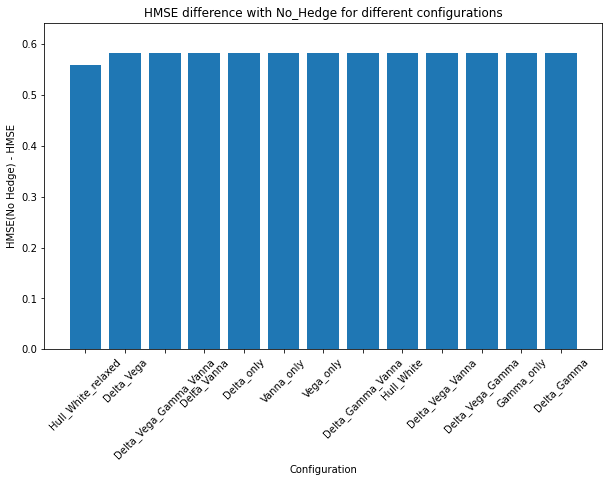

In [28]:
print('Improvement over No_Hedge strategy')
imp_dict = {}
for config in configurations:
    if config != 'No_Hedge' and config != 'BS':
        imp_dict[config] = hmse_dict['No_Hedge'] - hmse_dict[config]

# Sort the imp_dict by values (HMSE difference with No_Hedge)
sorted_imp_dict = {k: v for k, v in sorted(imp_dict.items(), key=lambda item: item[1])}

# Print HMSE difference for each configuration
for config, improvement in sorted_imp_dict.items():
    print(f'{config}: {improvement}')

# Define the starting value for the y-axis
y_axis_start = 0

# Plotting the HMSE values sorted by HMSE difference
plt.figure(figsize=(10, 6))
plt.bar(sorted_imp_dict.keys(), sorted_imp_dict.values())
plt.xlabel('Configuration')
plt.ylabel('HMSE(No Hedge) - HMSE')
plt.title('HMSE difference with No_Hedge for different configurations')
plt.xticks(rotation=45)

# Set the y-axis limits to start from the specified value
plt.ylim(y_axis_start, max(sorted_imp_dict.values()) * 1.1)  # You can adjust the multiplier for padding

plt.show()

